In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [2]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

Correlation: 0.9999999999999999
Cointegration test p-value: 0.0


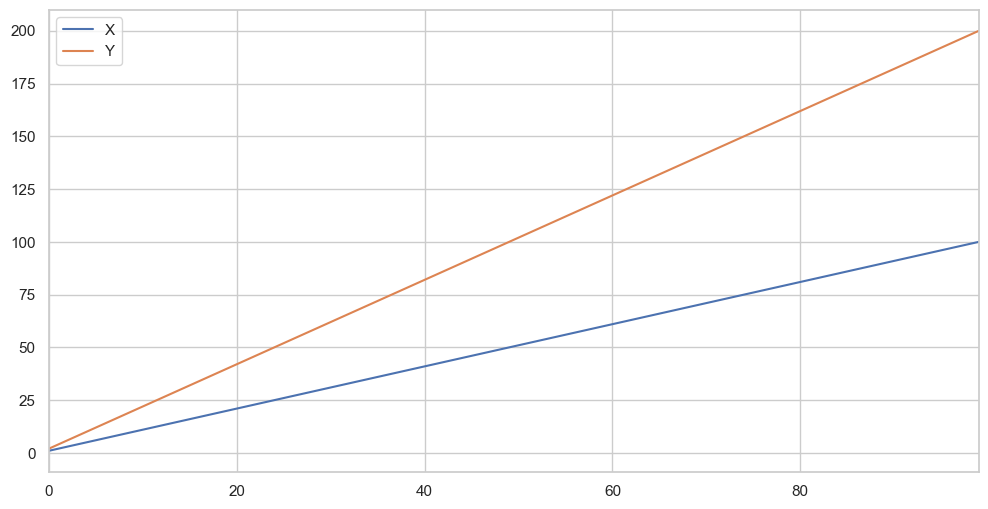

In [3]:
X_returns = np.random.normal(1, 0, 100)
Y_returns = np.random.normal(2, 0, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')


pd.concat([X_diverging, Y_diverging], axis=1).plot(figsize=(12,6))
plt.xlim(0, 99)

print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.014144188914441894
Cointegration test p-value: 0.0


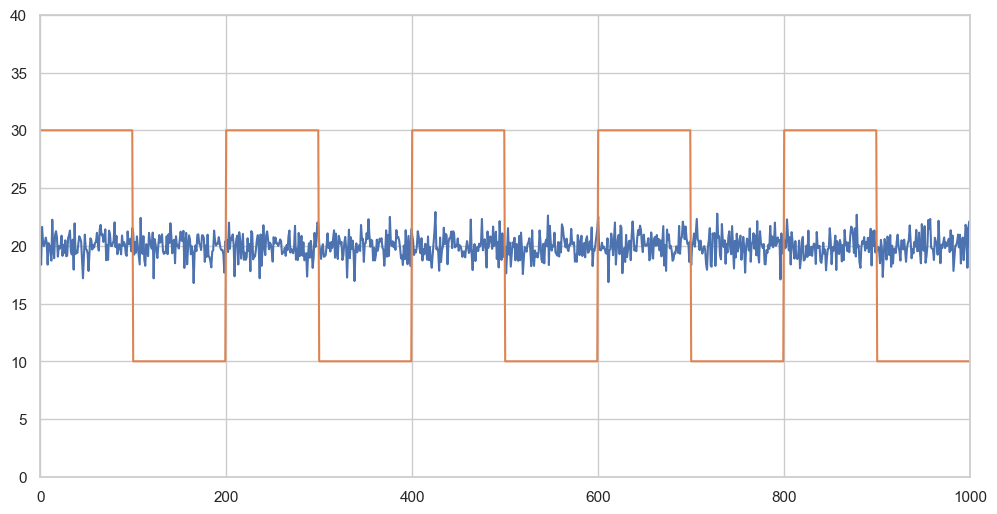

In [4]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10


plt.figure(figsize=(12,6))
Y2.plot()
Y3.plot()
plt.ylim([0, 40])
plt.xlim([0, 1000])

# correlation is nearly zero
print( 'Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print( 'Cointegration test p-value: ' + str(pvalue))

In [5]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [6]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [7]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']


df = yf.download(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  11 of 11 completed


Ticker,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2018-12-24,36.707500,205.160004,16.650000,26.139999,19.379999,102.839386,25.559999,94.129997,42.689999,53.650002,234.339996
2018-12-26,39.292500,222.949997,17.900000,27.850000,20.330000,106.491394,26.600000,100.559998,44.590000,55.959999,246.179993
2018-12-27,39.037498,225.139999,17.490000,28.030001,20.379999,108.776291,26.799999,101.180000,44.970001,56.090000,248.070007
2018-12-28,39.057499,223.130005,17.820000,28.240000,20.340000,108.059273,26.750000,100.389999,44.820000,56.810001,247.750000
2018-12-31,39.435001,226.240005,18.459999,28.070000,20.459999,108.671127,26.910000,101.570000,45.150002,56.910000,249.919998


[('AAPL', 'ORCL'), ('AAPL', 'SPY'), ('ADBE', 'MSFT'), ('AMD', 'MSFT'), ('HPQ', 'ORCL'), ('ORCL', 'SPY')]


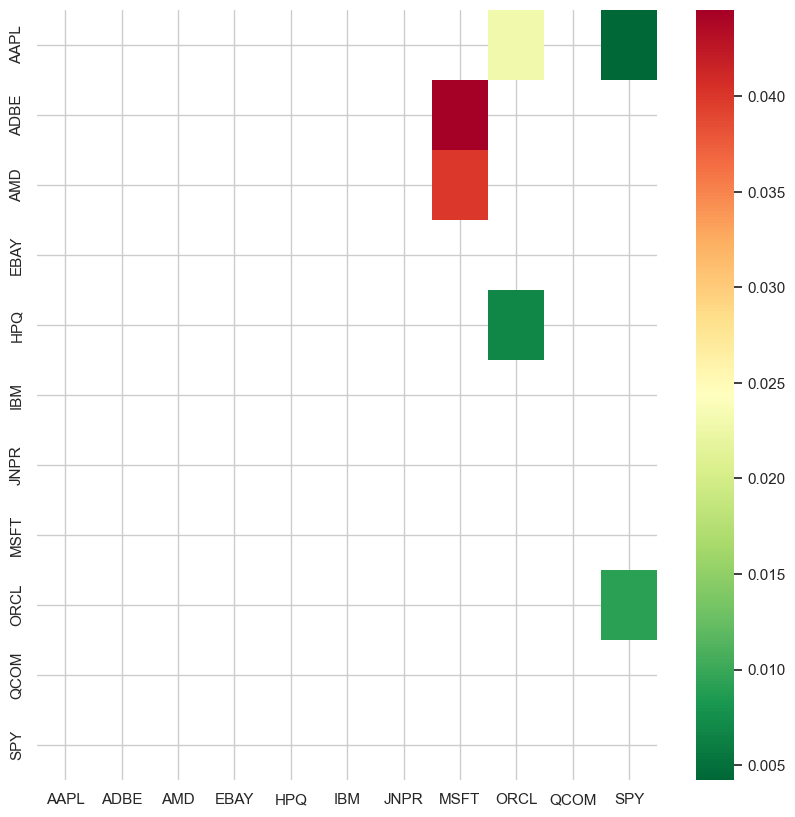

In [8]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [9]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

0.04452696271616793

In [10]:
S1

Date
2013-01-02     38.340000
2013-01-03     37.750000
2013-01-04     38.130001
2013-01-07     37.939999
2013-01-08     38.139999
                 ...    
2018-12-24    205.160004
2018-12-26    222.949997
2018-12-27    225.139999
2018-12-28    223.130005
2018-12-31    226.240005
Name: ADBE, Length: 1510, dtype: float64

In [11]:
S1.diff()

Date
2013-01-02          NaN
2013-01-03    -0.590000
2013-01-04     0.380001
2013-01-07    -0.190002
2013-01-08     0.200001
                ...    
2018-12-24    -3.639999
2018-12-26    17.789993
2018-12-27     2.190002
2018-12-28    -2.009995
2018-12-31     3.110001
Name: ADBE, Length: 1510, dtype: float64

In [12]:
ratio = S1/S2
ratio_change = ratio.diff()
ratio_lag = ratio.shift(1)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean().shift(1)
ratios_mavg60 = ratio.rolling(window=60, center=False).mean().shift(1)
ratios_mavg30 = ratio.rolling(window=30, center = False).mean().shift(1)
std_60 = ratio.rolling(window=60, center=False).std().shift(1)
std_30 = ratio.rolling(window=30, center= False).std().shift(1)
ratios_mavg10 = ratio.rolling(window=30, center=False).mean().shift(1)

In [13]:
data = {'ratio_change': ratio_change, 
        'prev_day_ratio' : ratio_lag,
        'avg_5' : ratios_mavg5,
        'avg_30' : ratios_mavg30,
        'avg_60' : ratios_mavg60,
        'std_30' : std_30,
        'std_60' : std_60}

In [14]:
temp_df = pd.DataFrame(data)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [16]:
y = temp_df['ratio_change']
X = temp_df[['prev_day_ratio', 'avg_5', 'avg_30', 'avg_60', 'std_30', 'std_60']]

In [17]:
X_train = X[62:1062]
y_train = y[62:1062]

In [18]:
rf = RandomForestRegressor(random_state = 38, n_estimators = 100)

In [19]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=38)

In [20]:
rf.feature_importances_

array([0.1560927 , 0.12432514, 0.14777008, 0.18386461, 0.17195156,
       0.21599592])

In [21]:
pred = rf.predict(X)

In [22]:
pred.shape

(1510,)

<Axes: xlabel='Date'>

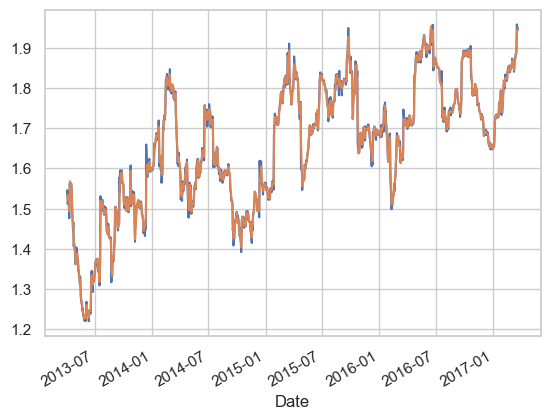

In [23]:
ratio[62:1062].plot()
(ratio_lag[62:1062] + pred[62:1062]).plot()

In [24]:
mse = mean_squared_error(pred[62:1062], ratio[62:1062])
rmse = mse ** 0.5

In [25]:
from scipy.stats import cumfreq

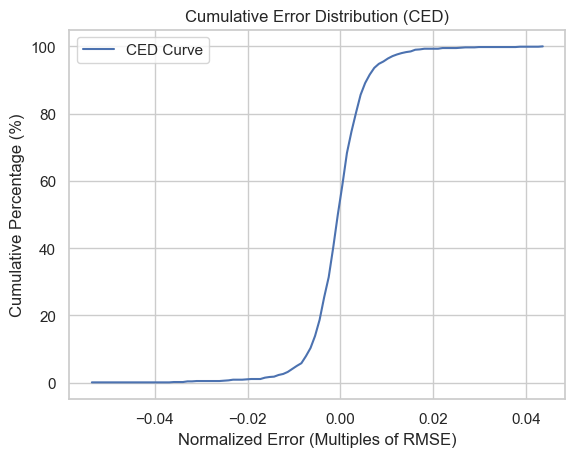

In [26]:
errors = rf.predict(X_train) - y_train
normalized_errors = errors / rmse

result = cumfreq(normalized_errors, numbins=100)

x = result.lowerlimit + np.linspace(0, result.binsize * result.cumcount.size, result.cumcount.size)
plt.plot(x, result.cumcount / len(errors) * 100, label='CED Curve')
plt.xlabel('Normalized Error (Multiples of RMSE)')
plt.ylabel('Cumulative Percentage (%)')
plt.title('Cumulative Error Distribution (CED)')
plt.legend()
plt.grid(True)
plt.show()


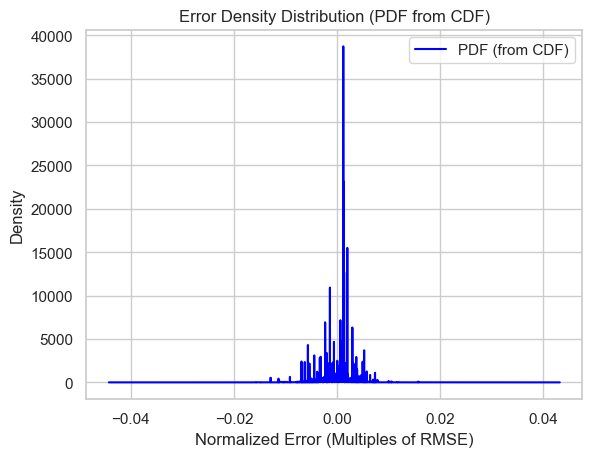

In [27]:
sorted_errors = np.sort(normalized_errors)
cumulative_percentages = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
x_vals = sorted_errors  
pdf_vals = np.diff(cumulative_percentages, prepend=0) / np.diff(sorted_errors, prepend=sorted_errors[0])
plt.step(x_vals, pdf_vals, label="PDF (from CDF)", where='mid', color='blue')
plt.xlabel("Normalized Error (Multiples of RMSE)")
plt.ylabel("Density")
plt.title("Error Density Distribution (PDF from CDF)")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
money = 0
countS1 = 0
countS2 = 0
notional_prof = 0
money_lis = []

for i in range(1062,1510):
    ratio_pred = ratio_lag[i] + rf.predict(np.array((ratio_lag[i],
                                                           ratios_mavg5[i], 
                                                           ratios_mavg30[i], 
                                                           ratios_mavg60[i],
                                                           std_30[i],
                                                           std_60[i])).reshape((1,-1)))
    if ratio_pred + 0.01*(rmse) < ratio[i] and ratio[i] < ratio_pred + 0.2 * (rmse):
        countS1 -= 1
        countS2 += int(ratio[i])
        money += S1[i] - int(ratio[i]) * S2[i]
        
    elif ratio_pred - 0.01 * rmse > ratio[i] and ratio[i] > ratio_pred - 0.2 * rmse:
        countS1 += 1
        countS2 -= int(ratio[i])
        money -= S1[i] - int(ratio[i]) * S2[i]
        
    else:
        countS1 = 0
        countS2 = 0
        money += S1[i] * countS1 + countS2 * S2[i]
    
    money_lis.append(money)

print(money,countS1,countS2)

13454.279876708984 -34 68


In [29]:
temp_df['earnings'] = np.array([0 for i in range(1062)] + (money_lis))
temp_df['earnings']

Date
2013-01-02        0.000000
2013-01-03        0.000000
2013-01-04        0.000000
2013-01-07        0.000000
2013-01-08        0.000000
                  ...     
2018-12-24    13364.219864
2018-12-26    13386.049866
2018-12-27    13408.829865
2018-12-28    13431.179871
2018-12-31    13454.279877
Name: earnings, Length: 1510, dtype: float64

In [30]:
pred_till_end = (rf.predict(temp_df[['prev_day_ratio', 'avg_5', 'avg_30', 'avg_60', 'std_30', 'std_60']].iloc[62:] ) + ratio_lag[62:])

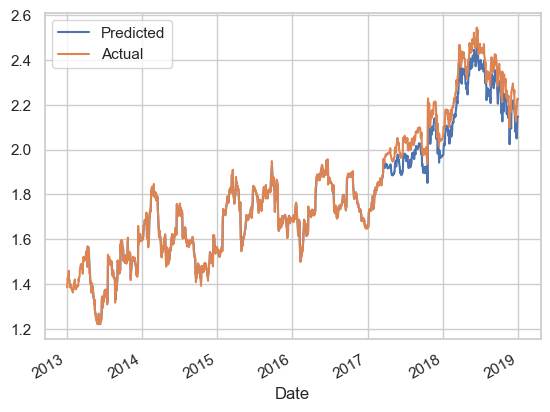

In [31]:
# (temp_df['earnings']/14000).plot()
pred_till_end.plot()
ratio.plot()
plt.legend(['Predicted', 'Actual'])

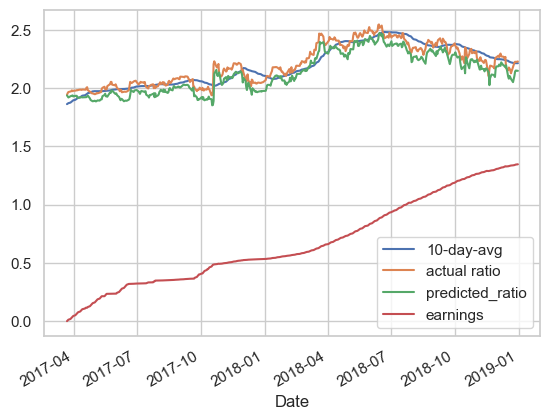

In [32]:
ratios_mavg10[1062:1510].plot()
ratio[1062:1510].plot()
pred_till_end[1000:1510].plot()
(temp_df['earnings'].iloc[1062:1510]/10000).plot()
plt.legend(['10-day-avg', 'actual ratio', 'predicted_ratio', 'earnings'])

In [33]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2022, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']


df2 = yf.download(tickers, start, end)['Close']
df2.tail()

[*********************100%***********************]  11 of 11 completed


Ticker,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2021-12-27,180.330002,577.679993,154.360001,65.660004,38.099998,131.619995,35.110001,342.450012,89.540001,186.330002,477.260010
2021-12-28,179.289993,569.359985,153.149994,66.080002,37.950001,132.630005,35.430000,341.250000,88.650002,184.820007,476.869995
2021-12-29,179.380005,569.289978,148.259995,66.459999,37.980000,133.350006,35.770000,341.950012,88.209999,186.199997,477.480011
2021-12-30,178.199997,570.530029,145.149994,66.779999,37.750000,133.910004,35.380001,339.320007,88.010002,182.729996,476.160004
2021-12-31,177.570007,567.059998,143.899994,66.500000,37.669998,133.660004,35.709999,336.320007,87.209999,182.869995,474.959991


[('AAPL', 'AMD'), ('EBAY', 'MSFT'), ('EBAY', 'ORCL'), ('EBAY', 'SPY')]


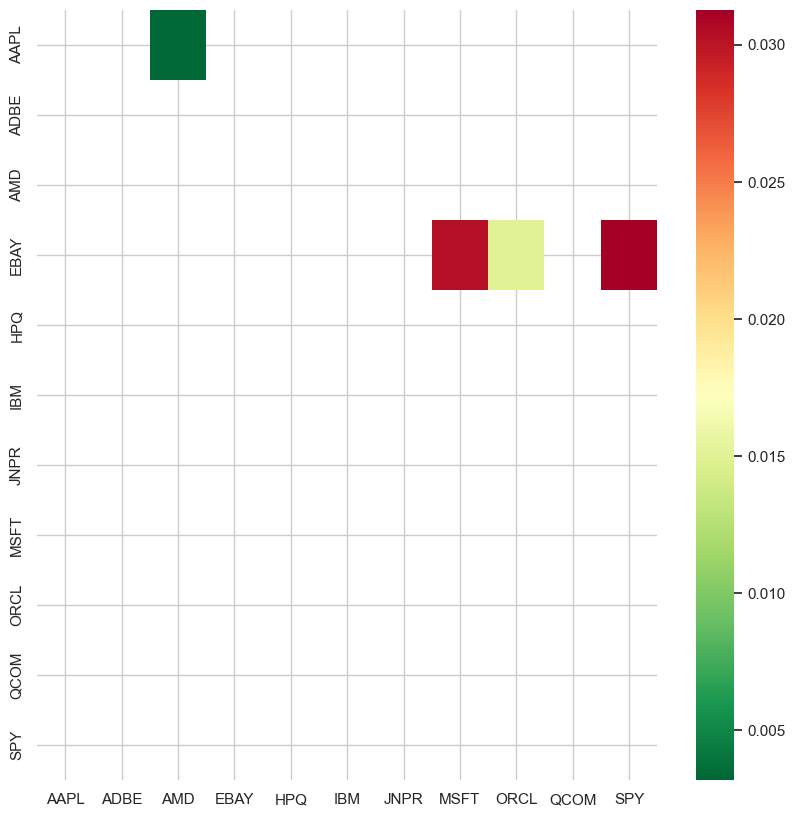

In [34]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df2)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [35]:
X_train = X[62:662]
y_train = y[62:662]

In [36]:
rf2 = RandomForestRegressor(random_state = 38, n_estimators = 100)

In [37]:
rf2.fit(X_train, y_train)

RandomForestRegressor(random_state=38)

In [38]:
pred2 = rf2.predict(X)

<Axes: xlabel='Date'>

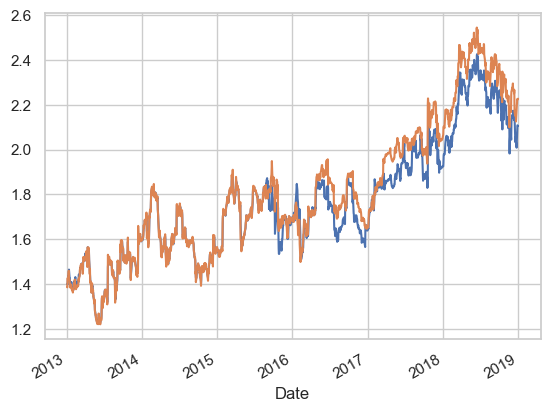

In [39]:
(pred2 + ratio_lag).plot()
ratio.plot()

In [40]:
mse = mean_squared_error(pred2[62:662], ratio[62:662])
rmse = mse ** 0.5

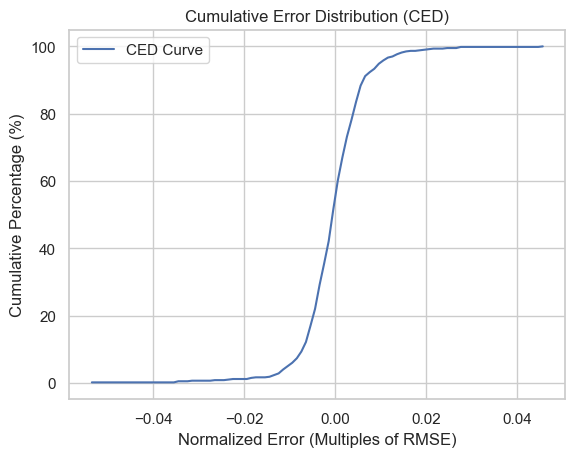

In [41]:
errors = rf2.predict(X_train) - y_train
normalized_errors = errors / rmse

result = cumfreq(normalized_errors, numbins=100)

x = result.lowerlimit + np.linspace(0, result.binsize * result.cumcount.size, result.cumcount.size)
plt.plot(x, result.cumcount / len(errors) * 100, label='CED Curve')
plt.xlabel('Normalized Error (Multiples of RMSE)')
plt.ylabel('Cumulative Percentage (%)')
plt.title('Cumulative Error Distribution (CED)')
plt.legend()
plt.grid(True)
plt.show()


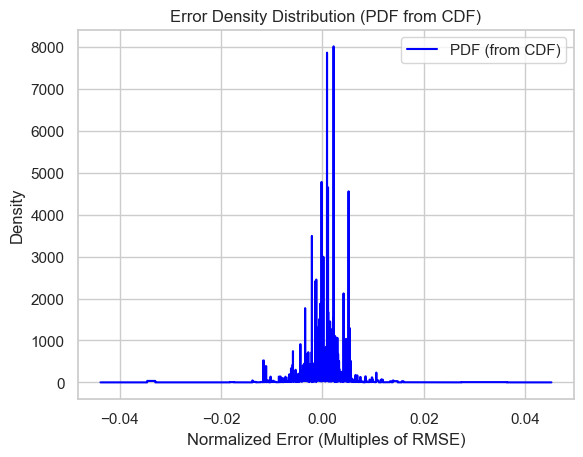

In [42]:
sorted_errors = np.sort(normalized_errors)
cumulative_percentages = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
x_vals = sorted_errors  
pdf_vals = np.diff(cumulative_percentages, prepend=0) / np.diff(sorted_errors, prepend=sorted_errors[0])
plt.step(x_vals, pdf_vals, label="PDF (from CDF)", where='mid', color='blue')
plt.xlabel("Normalized Error (Multiples of RMSE)")
plt.ylabel("Density")
plt.title("Error Density Distribution (PDF from CDF)")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
money = 0
countS1 = 0
countS2 = 0
notional_prof = 0
money_lis = []

for i in range(662,1510):
    ratio_pred = ratio_lag[i] + rf2.predict(np.array((ratio_lag[i],
                                                           ratios_mavg5[i], 
                                                           ratios_mavg30[i], 
                                                           ratios_mavg60[i],
                                                           std_30[i],
                                                           std_60[i])).reshape((1,-1)))
    if ratio_pred + 0.01*(rmse) < ratio[i] and ratio[i] < ratio_pred + 0.2 * (rmse):
        countS1 -= 1
        countS2 += int(ratio[i])
        money += S1[i] - int(ratio[i]) * S2[i]
        
    elif ratio_pred - 0.01 * rmse > ratio[i] and ratio[i] > ratio_pred - 0.2 * rmse:
        countS1 += 1
        countS2 -= int(ratio[i])
        money -= S1[i] - int(ratio[i]) * S2[i]
        
    else:
        countS1 = 0
        countS2 = 0
        money += S1[i] * countS1 + countS2 * S2[i]
    
    money_lis.append(money)

print(money,countS1,countS2)

22457.359951019287 -27 54


In [44]:
pred_till_end2 = (rf2.predict(temp_df[['prev_day_ratio', 'avg_5', 'avg_30', 'avg_60', 'std_30', 'std_60']].iloc[62:] ) + ratio_lag[62:])

In [45]:
temp_df['earnings2'] = np.array([0 for i in range(662)] + (money_lis))
temp_df['earnings2']

Date
2013-01-02        0.000000
2013-01-03        0.000000
2013-01-04        0.000000
2013-01-07        0.000000
2013-01-08        0.000000
                  ...     
2018-12-24    22367.299938
2018-12-26    22389.129940
2018-12-27    22411.909939
2018-12-28    22434.259945
2018-12-31    22457.359951
Name: earnings2, Length: 1510, dtype: float64

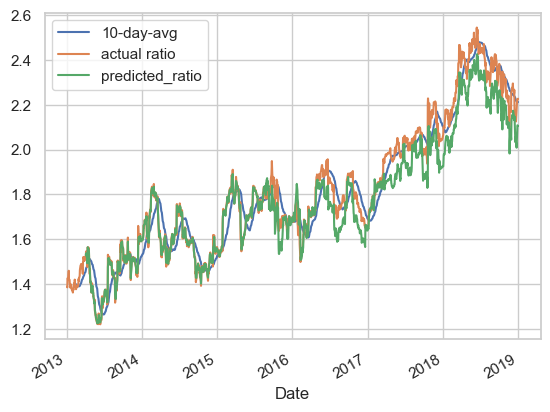

In [46]:
ratios_mavg10.plot()
ratio.plot()
pred_till_end2.plot()
# (temp_df['earnings2'].iloc[662:1510]/10000).plot()
plt.legend(['10-day-avg', 'actual ratio', 'predicted_ratio'])

<Axes: xlabel='Date'>

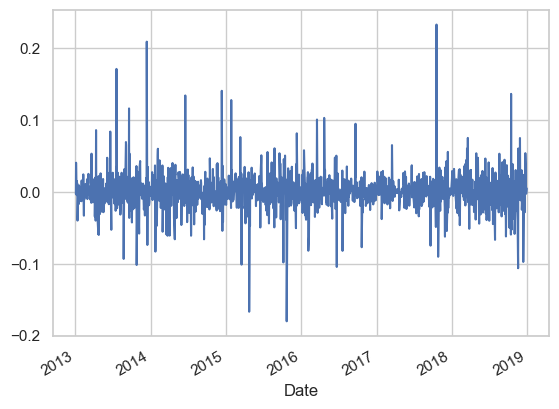

In [47]:
ratio_change.plot()

<Axes: xlabel='Date'>

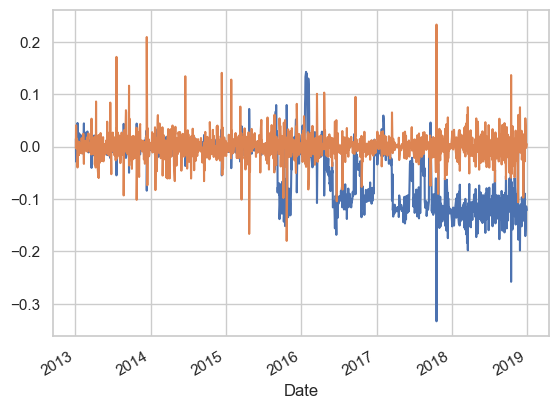

In [48]:
(pred2-ratio_change).plot()
# (pred2-ratio_change + ratio_change).plot()
ratio_change.plot()

<Axes: xlabel='Date'>

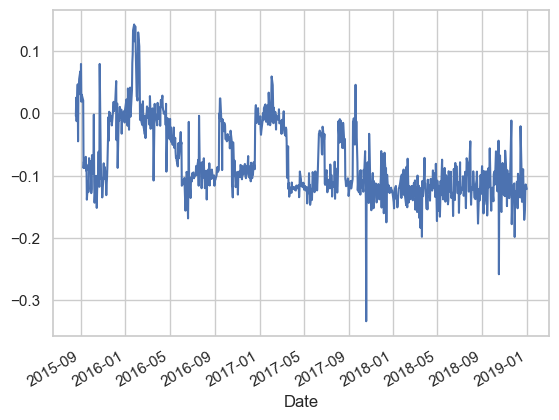

In [49]:
(pred_till_end2[600:] - ratio[662:]).plot()

In [74]:
X_train = X[600:1262]
y_train = y[600:1262]

In [75]:
rf3 = RandomForestRegressor(random_state = 38, n_estimators = 100)

In [76]:
rf3.fit(X_train, y_train)

RandomForestRegressor(random_state=38)

In [77]:
pred3 = rf3.predict(X)

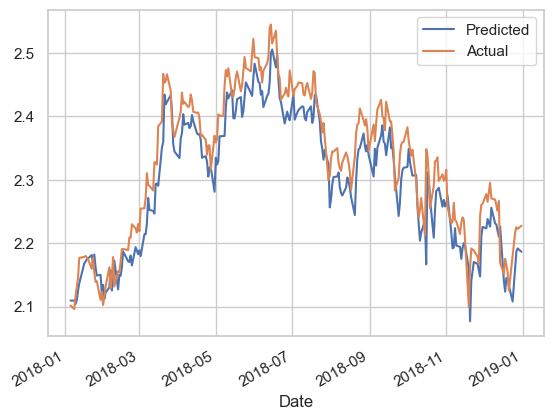

In [78]:
((pred3 + ratio_lag).iloc[1262:]).plot()
ratio.iloc[1262:].plot()
plt.legend(["Predicted", "Actual"])

<Axes: xlabel='Date'>

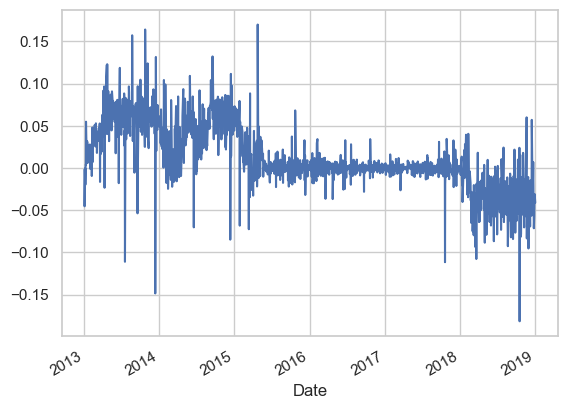

In [80]:
(pred3-ratio_change).plot()
# (pred2-ratio_change + ratio_change).plot()
# ratio_change.plot()

In [82]:
money = 0
countS1 = 0
countS2 = 0
notional_prof = 0
money_lis = []

for i in range(1262,1510):
    ratio_pred = ratio_lag[i] + rf3.predict(np.array((ratio_lag[i],
                                                           ratios_mavg5[i], 
                                                           ratios_mavg30[i], 
                                                           ratios_mavg60[i],
                                                           std_30[i],
                                                           std_60[i])).reshape((1,-1)))
    if ratio_pred + 0.01*(rmse) < ratio[i] and ratio[i] < ratio_pred + 0.2 * (rmse):
        countS1 -= 1
        countS2 += int(ratio[i])
        money += S1[i] - int(ratio[i]) * S2[i]
        
    elif ratio_pred - 0.01 * rmse > ratio[i] and ratio[i] > ratio_pred - 0.2 * rmse:
        countS1 += 1
        countS2 -= int(ratio[i])
        money -= S1[i] - int(ratio[i]) * S2[i]
        
    else:
        countS1 = 0
        countS2 = 0
        money += S1[i] * countS1 + countS2 * S2[i]
    
    money_lis.append(money)

print(money,countS1,countS2)

6137.529983520508 -5 10


In [83]:
temp_df['ratio'] = ratio
y = temp_df['ratio']
X = temp_df[['prev_day_ratio', 'avg_5', 'avg_30', 'avg_60', 'std_30', 'std_60']]

In [103]:
X_train = X[62:1262]
y_train = y[62:1262]

In [104]:
rf4 = RandomForestRegressor(random_state = 38, n_estimators = 100)

In [105]:
rf4.fit(X_train, y_train)

RandomForestRegressor(random_state=38)

In [106]:
pred4 = rf4.predict(X)

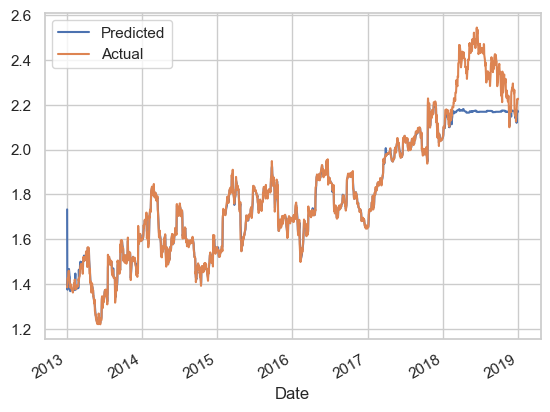

In [107]:
((pred4 + ratio - ratio)).plot()
ratio.plot()
plt.legend(["Predicted", "Actual"])

In [109]:
from sklearn import svm

In [112]:
svr_model = svm.SVR(kernel='rbf', C = 100, gamma = 0.1, epsilon=0.1)

In [123]:
y = temp_df['ratio_change']
X_train = X[62:662]
y_train = y[62:662]

In [124]:
svr_model.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [125]:
y_pred = svr_model.predict(X[62:])

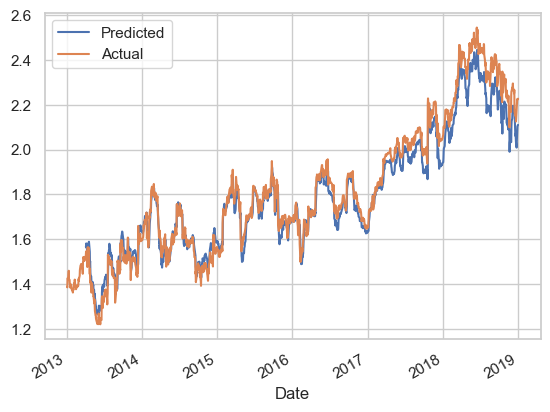

In [129]:
(y_pred + ratio_lag[62:]).plot()
ratio.plot()
plt.legend(["Predicted", "Actual"])

In [130]:
y = temp_df['ratio']
X_train = X[62:662]
y_train = y[62:662]

In [131]:
svr_model.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [132]:
y_pred = svr_model.predict(X[62:])

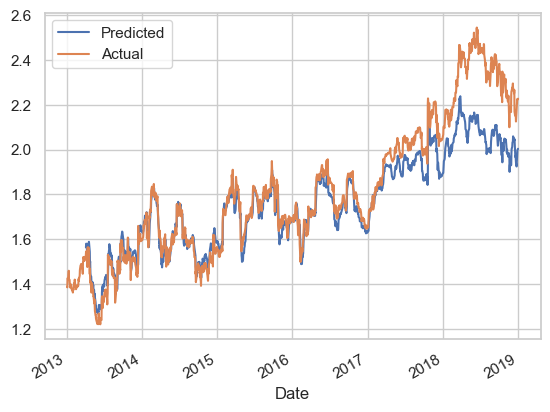

In [134]:
(y_pred + ratio[62:] - ratio[62:]).plot()
ratio.plot()
plt.legend(["Predicted", "Actual"])